In [1]:
import gym
import numpy as np
from gym.envs.registration import register
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
import seaborn as sns

plt.style.use("ggplot")

In [2]:
# Set Up environment
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)
frozen_lake_env = gym.make("FrozenLakeNotSlippery-v0")
env = frozen_lake_env.env

In [3]:
def eGreedy(Q, state, epsilon):
    q_vals = Q[state, :]
    
    if np.random.rand() > epsilon:
        return np.argmax(q_vals)
    else:
        return np.random.randint(len(q_vals))
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth    

In [4]:
# Dyna-Q Agent
# Can also implement Dyna-Q+ if agent adds reward to untested actions
# r' = r + k * sqrt(t), t is time since last time state was visited
def trainDyna(env, num_episodes, epsilon, n=0, alpha=0.1, gamma=0.99, max_iters=200):
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    model = defaultdict(lambda: (0,0))
    
    total_rewards = np.zeros(num_episodes)
    
    pbar = tqdm(range(num_episodes))
    for ep in pbar:
        
        ep_rewards = 0
        t = 0
        state = env.reset()
        done = False
        while not done:
            
            action = eGreedy(Q, state, epsilon(ep))
            
            next_state, reward, done, _ = env.step(action)

            # Update Value Fcn
            target = reward + gamma * np.amax(Q[next_state, :])
            estimate = Q[state, action]
            Q[state, action] += alpha * (target - estimate)
            
            # Update Model
            model[(state, action)] = (next_state, reward)
            
            # Plan n steps into future and use it to update Value Fcn
            for i in range(n):
                
                # Only loop over (S,A) pairs seen
                observed_states = [i[0] for i in list(model.keys())]
                actions_taken = [i[1] for i in list(model.keys())]
                
                # Randomly sample (S,A) pair
                state_plan = np.random.choice(observed_states)
                action_plan = np.random.choice(actions_taken)
                
                next_state_plan, reward_plan = model[(state_plan, action_plan)]
                
                # Update Value Fcn
                target = reward_plan + gamma * np.amax(Q[next_state_plan, :])
                estimate = Q[state_plan, action_plan]
                Q[state_plan, action_plan] += alpha * (target - estimate)
            
            if t > max_iters: break
            t += 1
            state = next_state
            ep_rewards += reward
            
            pbar.set_description("Total Rewards: {}".format(sum(total_rewards)))
        
        total_rewards[ep] = ep_rewards
    return total_rewards

In [15]:
num_episodes = 1000
anneal_steps = 500
initial_eps = 1.0
def epsilon(t):
    fraction = min(float(t) / anneal_steps, 1.0)                           
    return initial_eps - fraction * initial_eps
  
# Test with planning horizon of 0 and 50
n_vec = range(10)
rewards = np.zeros((len(n_vec), num_episodes))
for i,n in enumerate(n_vec):
    rewards[i] = trainDyna(env, num_episodes, epsilon, n=n, max_iters=50)

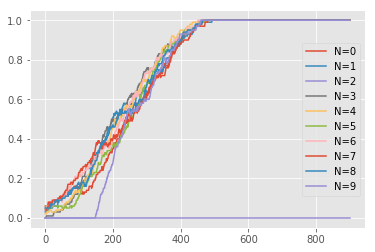

In [17]:
for reward in rewards:
    plt.plot(smooth(reward, 100))
plt.legend(["N={}".format(i) for i in n_vec])
plt.show()